In [1]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dfv = pd.read_csv('./VideoInfo.csv')
dfv.head(2)

,video_id,duration
0,2ad9d36d334a204a8bec40476171688f,213.00
1,6b11f01854f0399d87789a6315571466,297.17


In [3]:
tr_label = pd.read_csv('./TrainLabel.csv')
tr_df = pd.read_csv('./TrainFeatures.csv')
ts_df = pd.read_csv('./TestFeatures.csv')
ts = pd.read_csv('./TestData.csv')

# scan data

In [4]:
tr_df.head(2)

,user_id,video_id,session,new_speed,old_speed,new_time,old_time,event_type,event_time
0,ff930d24cbdeb11e6dde8ceb0da5ac64,1300c72423ed68023f9793fe9d024038,17e163d9ff1f6cc57ca6a7e47a2db93e,NaN,NaN,NaN,NaN,load_video,2015-03-30 12:31:27.727452
1,ff930d24cbdeb11e6dde8ceb0da5ac64,ae849c393655910a93279697dfd2f41d,17e163d9ff1f6cc57ca6a7e47a2db93e,NaN,NaN,NaN,NaN,load_video,2015-03-30 12:33:26.764407


In [5]:

tr_label.head(2)

,user_id,grade
0,bd4c9ab730f5513206b999ec0d90d1fb,0
1,d2a27e83d429f0dcae6b937cf440aeb1,0


In [6]:
ts.head(2)

,user_id
0,2647c1dba23bc0e0f9cdf75339e120d2
1,d0921d442ee91b896ad95059d13df618


In [7]:
tr_df.shape,tr_label.shape

((2048666, 9), (5050, 2))

### null rate

In [8]:
(tr_df.shape[0] - tr_df.count())/float(tr_df.shape[0])

user_id       0.000000
video_id      0.000000
session       0.000000
new_speed     0.993472
old_speed     0.993472
new_time      0.837754
old_time      0.837754
event_type    0.000000
event_time    0.000000
dtype: float64

### shapes-test data

In [9]:
ts_df.shape,ts.shape

((514041, 9), (1293, 1))

## label distribution

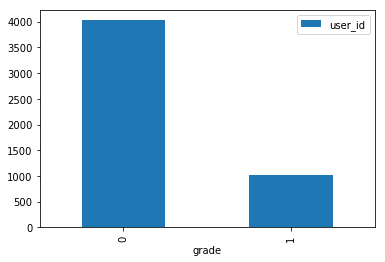

In [10]:
tr_label.groupby('grade').count().plot(kind = 'bar')

### tr_label.groupby('grade').count().plot(kind = 'bar')

## Generate Features

### vedio read times

In [11]:
watched_videos =tr_df.groupby(['user_id']).agg({'video_id':lambda x:np.unique(x).shape[0]})
watched_videos.columns = ['watched_videos']
watched_videos.head(3)

,watched_videos
user_id,
0005266eb37020aaa9d87eccc6d051b3,48
00283999ebb74c7052f962400b51af1b,63
003cb7ee2f970b407b0087075b41b608,14


In [12]:
xv =ts_df.groupby(['user_id']).agg({'video_id':lambda x:np.unique(x).shape[0]})
xv.columns = ['watched_videos']
xv.head(2)

,watched_videos
user_id,
00069663a97a439538d04d3a7cd659a1,37
004fbc40e3999cb7575fce07a1fc8b7a,29


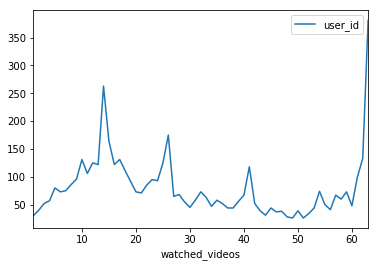

In [13]:
watched_videos.reset_index().groupby('watched_videos').count().plot()

### Time session

In [14]:
session_count = tr_df.groupby(['user_id']).agg({'session':lambda x:np.unique(x).shape[0]})
session_count.head(1)

,session
user_id,
0005266eb37020aaa9d87eccc6d051b3,4


In [15]:
xs = ts_df.groupby(['user_id']).agg({'session':lambda x:np.unique(x).shape[0]})
xs.head(1)

,session
user_id,
00069663a97a439538d04d3a7cd659a1,3


#### average actions/sesion

In [16]:
session_action_mean = tr_df.groupby(['user_id'])['event_type','session'].agg(lambda g:g['event_type'].count()/np.unique(g['session']).shape[0]).rename(columns={'event_type':'avg_acts_sess'})['avg_acts_sess']
pd.DataFrame(session_action_mean).head(1)

,avg_acts_sess
user_id,
0005266eb37020aaa9d87eccc6d051b3,39


In [17]:
xsa_mean = ts_df.groupby(['user_id'])['event_type','session'].agg(lambda g:g['event_type'].count()/np.unique(g['session']).shape[0]).rename(columns={'event_type':'avg_acts_sess'})['avg_acts_sess']
pd.DataFrame(xsa_mean).head(1)

,avg_acts_sess
user_id,
00069663a97a439538d04d3a7cd659a1,113


### time_scale_sum&skip_scale_videos

In [18]:
time_scale_sum = tr_df.groupby(['user_id'])['old_time','new_time'].agg(lambda g: abs(g['new_time']- g['old_time']).sum()).rename(columns={'old_time':'time_scale_sum'})['time_scale_sum']
time_scale_sum.head(1)
skip_scale_videos = (time_scale_sum.values.reshape(5050,1)/watched_videos).rename(columns = {'watched_videos':'skip_scale_videos'})
skip_scale_videos.head(1)

,skip_scale_videos
user_id,
0005266eb37020aaa9d87eccc6d051b3,0.535259


In [19]:
ts_df.shape[0]

514041

In [20]:
xt_sum = ts_df.groupby(['user_id'])['old_time','new_time'].agg(lambda g: abs(g['new_time']- g['old_time']).sum()).rename(columns={'old_time':'time_scale_sum'})['time_scale_sum']
xt_sum.head(1)
n=ts_df.shape[0]
skip_scale_videos = (xt_sum.values.reshape(1293,1)/xv).rename(columns = {'watched_videos':'skip_scale_videos'})
skip_scale_videos.head(1)

,skip_scale_videos
user_id,
00069663a97a439538d04d3a7cd659a1,72.794175


### event types count

In [21]:
tr_df.groupby(['user_id','event_type']).count().head(4)

video_id  session  new_speed  \
user_id                          event_type                                  
0005266eb37020aaa9d87eccc6d051b3 load_video        113      113          0   
                                 pause_video        16       16          0   
                                 play_video         19       19          0   
                                 seek_video          1        1          0   

                                              old_speed  new_time  old_time  \
user_id                          event_type                                   
0005266eb37020aaa9d87eccc6d051b3 load_video           0         0         0   
                                 pause_video          0         0         0   
                                 play_video           0         0         0   
                                 seek_video           0         1         1   

                                              event_time  
user_id                          event_type               
0005266eb37020aaa9d87eccc6d051b3 load_video          113  
                                 pause_video          16  
                                 play_video           19  
                                 seek_video            1

In [22]:
event = tr_df.groupby(['user_id','event_type']).count()['video_id']
user_events = event.unstack().fillna('0')
# less improve by average
for column in user_events.columns:
    user_events[column] = user_events[column].astype('float',copy=True)
# for i in user_events.index:
#     user_events.loc[i,:] =  user_events.loc[i,:]/float(watched_videos.loc[i,'watched_videos'])

user_events.head(5)

event_type,load_video,pause_video,play_video,seek_video,speed_change_video,stop_video
user_id,,,,,,
0005266eb37020aaa9d87eccc6d051b3,113.0,16.0,19.0,1.0,0.0,8.0
00283999ebb74c7052f962400b51af1b,243.0,122.0,609.0,33.0,1.0,50.0
003cb7ee2f970b407b0087075b41b608,25.0,35.0,63.0,33.0,2.0,4.0
004cab314f7310363f7a802369867f9e,87.0,71.0,143.0,38.0,0.0,33.0
006c65a0946666507fd85ad824ff5909,133.0,208.0,257.0,44.0,0.0,48.0


In [23]:
xe = ts_df.groupby(['user_id','event_type']).count()['video_id']
user_xe = xe.unstack().fillna('0')
# less improve by average
# for column in user_events.columns:
#     user_events[column] = user_events[column].astype('float',copy=True)
# for i in user_events.index:
#     user_events.loc[i,:] =  user_events.loc[i,:]/float(watched_videos.loc[i,'watched_videos'])


## combine features

In [24]:
features = watched_videos.join([user_events,time_scale_sum,session_action_mean])
print features.shape
features.head(2)

(5050, 9)


,watched_videos,load_video,pause_video,play_video,seek_video,speed_change_video,stop_video,time_scale_sum,avg_acts_sess
user_id,,,,,,,,,
0005266eb37020aaa9d87eccc6d051b3,48,113.0,16.0,19.0,1.0,0.0,8.0,25.692416,39
00283999ebb74c7052f962400b51af1b,63,243.0,122.0,609.0,33.0,1.0,50.0,1736.581055,58


In [25]:
x = xv.join([user_xe,xt_sum,xsa_mean])
x.head()

,watched_videos,load_video,pause_video,play_video,seek_video,speed_change_video,stop_video,time_scale_sum,avg_acts_sess
user_id,,,,,,,,,
00069663a97a439538d04d3a7cd659a1,37,97.0,46,100,52,0,44,2693.384474,113
004fbc40e3999cb7575fce07a1fc8b7a,29,32.0,44,286,12,0,7,721.027000,47
00936d9181fad38deec90d2af5baf0a0,11,16.0,24,33,227,0,0,2640.164063,75
00a98ff25199a9bab6cb5954be4f6d27,19,45.0,31,45,7,23,14,285.530347,41
00b59133ff74f750038ac45cc8ab190d,25,58.0,45,77,28,0,26,864.244418,23


In [26]:
x.shape

(1293, 9)

In [27]:
tr_y = tr_label.set_index('user_id').sort_index()

# analysis data features 


In [28]:
features.describe()

,watched_videos,load_video,pause_video,play_video,seek_video,speed_change_video,stop_video,time_scale_sum,avg_acts_sess
count,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000,5050.000000
mean,30.450099,65.414257,78.906535,169.986139,65.819406,2.648119,22.901980,2017.604401,80.902376
std,19.112762,56.986753,154.592933,351.881698,139.012791,8.271460,37.041995,3355.208648,151.660457
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,14.000000,23.000000,11.000000,25.000000,4.000000,0.000000,4.000000,166.225690,24.000000
50%,26.000000,48.000000,36.000000,73.000000,22.000000,0.000000,15.000000,859.371884,47.000000
75%,46.000000,93.000000,88.000000,187.000000,70.000000,2.000000,35.000000,2417.048388,89.000000
max,63.000000,501.000000,3717.000000,9442.000000,3532.000000,211.000000,2031.000000,44081.477421,4494.000000


## outliers detection

In [29]:
from sklearn.neighbors import LocalOutlierFactor

temp = features
# print features.join(tr_label)
# tr_label
clf = LocalOutlierFactor(n_neighbors=30,contamination=0.08,p=2)
outliers = clf.fit_predict(features)
print np.sort(clf.negative_outlier_factor_)
print 'features:',features[outliers ==-1].shape,'from ',features.shape
# print features[outliers ==-1].index
ff = features.drop(features[outliers ==-1].index)
tr_y = tr_y.drop(features[outliers ==-1].index)
features = ff

[-7.50659658 -6.31687538 -4.09972675 ..., -0.95480778 -0.95208827
 -0.94737616]
features: (404, 9) from  (5050, 9)


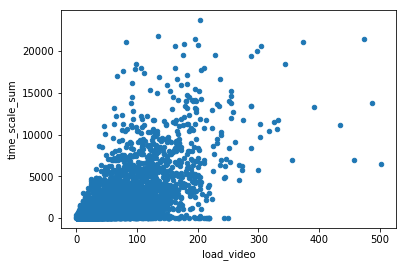

In [30]:
features.plot(x='load_video',y='time_scale_sum',kind = 'scatter')

In [31]:
features.shapefeatures = temp
features.shape

(4646, 9)

In [32]:
ff.shape

(4646, 9)

## Resample

In [33]:
# from collections import Counter
# from imblearn.combine import SMOTEENN
# print('Resampled dataset shape {}'.format(Counter(tr_y)))
# clf = SMOTEENN(random_state=0)
# # clf = RandomOverSampler(random_state=2)
# x_res, y_res = clf.fit_sample(features, tr_y.values)
# print('Resampled dataset shape {}'.format(Counter(y_res)))
# # print pd.DataFrame(x_res)
# features=pd.DataFrame(x_res)
# tr_y = pd.DataFrame(y_res)
# -features.shape[0]/5

## Training Process

In [34]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler,ADASYN,SMOTE
from imblearn.combine import SMOTEENN
from collections import Counter
# import xgboost as xgb

split = -features.shape[0]/5
xx = features.iloc[:split,:]
yy = tr_y.iloc[:split,:].values
xxx =  features.iloc[split:,:]
yyy = tr_y.iloc[split:,:].values


# >>>>>>>>>>>> ReSample    >>>>>>>>>>>>>>>>>>>>>

# from collections import Counter
# from imblearn.combine import SMOTEENN,SMOTETomek
# print('Resampled dataset shape {}'.format(Counter(tr_y)))
# clf = SMOTETomek(random_state=0)
# # clf = RandomOverSampler(random_state=2)
# x_res, y_res = clf.fit_sample(xx, yy)
# print('Resampled dataset shape {}'.format(Counter(y_res)))
# # print pd.DataFrame(x_res)
# xx =x_res
# yy =y_res


ros = RandomOverSampler(random_state=200)
# ros = SMOTE(random_state=200)
# xx_temp, yy_temp = ros.fit_sample(xx, yy)
xx, yy = ros.fit_sample(xx, yy)
print('Resampled dataset shape {}'.format(Counter(yy)))


# #combine
# xx = np.concatenate((xx, xx_temp), axis=0)
# yy = np.concatenate((yy, yy_temp), axis=0)

# >>>>>>>>>>>> shuffle   >>>>>>>>>>>>>>>>>>>
# ratio = 0.8
# random_index = np.arange(features.shape[0])
# np.random.shuffle(random_index)
# features = features[random_index]
# cut_num = np.int(0.8*features.shape[0])
# x_features = features[]
# val_features = 
# x_labels = 
# val_labels = 

# >>>>>>>>>>>> model selection >>>>>>>>>>>>>>>>>>>>>>
# clf = svm.LinearSVC(class_weight={0:1,1:2}) # 0.673
# clf = SGDClassifier(n_iter=100,alpha=0.0005)
clf = RandomForestClassifier()#class_weight={0:1,1:1},max_depth=15,max_leaf_nodes=19
# clf = MLPClassifier(hidden_layer_sizes=80,activation = 'relu',learning_rate='invscaling')
# clf = LogisticRegression()
# clf = AdaBoostClassifier()
# clf = svm.SVC(kernel='linear', class_weight={1: 10})
#>>>xgboost
# param = {'max_depth':15, 'eta':0.2, 'silent':0, 'objective':'binary:logistic','min_child_weight':3,'gamma':11 }  
# watchlist  = [(dtest,'eval'), (dtrain,'train')]  
# # watchlist  = [(dtrain,'train')]  
# num_round = 1
# bst = xgb.train(param, xx, num_round, watchlist)  
# # this is prediction  
# preds = bst.predict(dtest)  
# labels = dtest.get_label()

# >>>>>>>>>>>> CV   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

scores = cross_val_score(clf,xx,yy,cv=5)
print 'cv accuracy: %.3f +- %.3f' % (np.mean(scores),np.std(scores))
# print ('error=%f' % ( sum(1 for i in range(len(preds)) if int(preds[i]>0.5)!=tr_label[i]) /float(len(preds))))
# clf = LinearRegression()
# # clf = Lasso(alpha=1)
# # clf = LassoCV(alphas = [1, 2, 0.001, 0.0005,0.5])
# clf.fit(features,tr_label) #转成列向量
# test_y = clf.predict(test_x)
# print('regression args:')
# clf.coef_
# print clf.get_params()
# clf.feature_importances_
# >>>>
# scores = cross_val_score(clf,x_res,y_res,cv=10)
# print 'all cv accuracy: %.3f +- %.3f' % (np.mean(scores),np.std(scores))

# >>>>>>>>>>>> TR and TS  for all    >>>>>>>>>>>>>>>>>>>>>>>>>>>>>


y = clf.fit(xx,yy)
# preds = clf.predict(features[tr_y.grade>0.5])
preds = clf.predict(xxx)
# preds = clf.predict(xxx)

def CorrectRate(result, label):
    temp = {'TP':0.0,'TN':0.0,'FP':0.0,'FN':0.0}
    for i in range(len(result)):
        if label[i] == 1:
            if result[i] == 1:
                temp['TP'] +=1
            else:
                temp['FN'] +=1
        else:
            if result[i] == 0:
                temp['TN'] +=1
            else:
                temp['FP'] +=1
    return temp
# print 'all rate:',CorrectRate(preds, tr_y[tr_y.grade>0.5].grade)
eva = CorrectRate(preds, yyy)#tr_y.grade
# print 'featues:',list(features.columns)
print 'xx number: ',xx.shape[0],'True:',sum(yy),'False:',xx.shape[0]-sum(yy)
print 'xxx number:',xxx.shape[0],'Ture:',sum(yyy),'False:',xxx.shape[0]-sum(yyy)
print '1 :',eva['TP']+eva['FP'],'0: ',eva['TN']+eva['FN']
print 'accuracy:',(eva['TP']+eva['TN'])/len(yyy)
print 'precision',eva['TP']/(eva['TP']+eva['FP']+1),'预测为1中的正确率'
print 'recall',eva['TP']/((eva['TP']+eva['FN'])+1),'真正的1中预测率'
print '0 acc:',eva['TN']/(xxx.shape[0]-sum(yyy))
print '1 acc:',eva['TP']/sum(yyy),'recall'

/Users/lucas/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Resampled dataset shape Counter({0: 3014, 1: 3014})
cv accuracy: 0.950 +- 0.006
xx number:  6028 True: 3014 False: 3014
xxx number: 930 Ture: [179] False: [751]
1 : 168.0 0:  762.0
accuracy: 0.861290322581
precision 0.644970414201 预测为1中的正确率
recall 0.605555555556 真正的1中预测率
0 acc: [ 0.92143808]
1 acc: [ 0.60893855] recall


In [35]:
print list(clf.feature_importances_)


[0.30768764983093522, 0.19117362324273662, 0.073394382396739788, 0.049068820981971011, 0.045687163940099446, 0.022859757624537028, 0.15939239483180662, 0.060130634906160885, 0.090605572245013491]


# Predict

In [36]:
ros = RandomOverSampler(random_state=200)
print('Resampled dataset shape {}'.format(Counter(tr_y['grade'])))
xx, yy = ros.fit_sample(features, tr_y)
print('Resampled dataset shape {}'.format(Counter(yy)))
clf = RandomForestClassifier()
y = clf.fit(xx,yy)
# preds = clf.predict(features[tr_y.grade>0.5])
pre =clf.predict(x)

Resampled dataset shape Counter({0: 3765, 1: 881})
Resampled dataset shape Counter({0: 3765, 1: 3765})


In [37]:
out = pd.DataFrame(pre,index = x.index,columns = ['grade']).reset_index()
print out['grade'].sum()
out.head(3)

250


,user_id,grade
0,00069663a97a439538d04d3a7cd659a1,0
1,004fbc40e3999cb7575fce07a1fc8b7a,0
2,00936d9181fad38deec90d2af5baf0a0,0


In [38]:
out.to_csv('A3_gluab_20454477_Q1prediction.csv',index = 0)